Working out the bugs in my new object that implements assembly bias in a continuous way. 

In [50]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [51]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

In [52]:
from pearce.mocks.kittens import cat_dict
from copy import deepcopy
import numpy as np
from scipy.stats import binned_statistic, linregress
from pearce.mocks import cat_dict, compute_prim_haloprop_bins

In [53]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[0.658, 1.0]}

In [54]:
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

[0.658, 1.0]
[0.075, 0.077, 0.079, 0.0811, 0.0833, 0.0855, 0.0877, 0.0901, 0.0925, 0.0949, 0.0974, 0.1, 0.1027, 0.1054, 0.1082, 0.111, 0.114, 0.117, 0.1201, 0.1233, 0.1266, 0.1299, 0.1334, 0.1369, 0.1405, 0.1443, 0.1481, 0.152, 0.156, 0.1602, 0.1644, 0.1688, 0.1733, 0.1778, 0.1826, 0.1874, 0.1924, 0.1975, 0.2027, 0.2081, 0.2136, 0.2193, 0.2251, 0.231, 0.2372, 0.2434, 0.2499, 0.2565, 0.2633, 0.2703, 0.2775, 0.2848, 0.2924, 0.3001, 0.3081, 0.3162, 0.3246, 0.3332, 0.3421, 0.3511, 0.3604, 0.37, 0.3798, 0.3899, 0.4002, 0.4108, 0.4217, 0.4329, 0.4444, 0.4562, 0.4682, 0.4807, 0.4934, 0.5065, 0.5199, 0.5337, 0.5478, 0.5624, 0.5773, 0.5926, 0.6083, 0.6244, 0.641, 0.658, 0.6754, 0.6933, 0.7117, 0.7306, 0.7499, 0.7698, 0.7902, 0.8112, 0.8327, 0.8547, 0.8774, 0.9007, 0.9245, 0.9491, 0.9742, 1.0]


In [55]:
cat.load(1.0, HOD='hsabRedMagic')

In [56]:
fiducial_point = {'logM0': 12.0, 'logM1': 13.2, 'alpha': 1.02,
                      'logMmin': 12.0, 'f_c':1.0, 'sigma_logM': 0.60}

In [57]:
fiducial_point['mean_occupation_centrals_assembias_param1'] = 1.0
fiducial_point['mean_occupation_satellites_assembias_param1'] = 1.0

In [58]:
fiducial_point['disp_func_slope'] = 1.0 #1e-9

In [59]:
hod_params = dict(fiducial_point)
cat.populate(hod_params)

In [60]:
cen_occ = cat.model.model_dictionary['centrals_occupation']

In [61]:
cen_occ.param_dict

{'f_c': 1.0,
 'logMmin': 12.0,
 'mean_occupation_centrals_assembias_param1': 1.0,
 'sigma_logM': 0.6}

In [62]:
prim_haloprop = cat.halocat.halo_table[cen_occ.prim_haloprop_key]
sec_haloprop = cat.halocat.halo_table[cen_occ.sec_haloprop_key]

In [63]:
prim_haloprop_bins = compute_prim_haloprop_bins(prim_haloprop = prim_haloprop)

In [64]:
baseline_result = cen_occ.baseline_mean_occupation(prim_haloprop = prim_haloprop)
split = cen_occ.percentile_splitting_function(prim_haloprop = prim_haloprop)

In [65]:
no_edge_mask = ((split > 0) & (split < 1))

In [66]:
perturbation = cen_occ._galprop_perturbation(
    baseline_result = baseline_result[no_edge_mask],
    prim_haloprop = prim_haloprop[no_edge_mask],
    sec_haloprop = sec_haloprop[no_edge_mask],
    splitting_result = split[no_edge_mask])

In [67]:
final_result = cen_occ.mean_occupation(prim_haloprop = prim_haloprop, sec_haloprop = sec_haloprop)

In [68]:
bin_slice = prim_haloprop_bins%5 == 0

In [69]:
pal = sns.cubehelix_palette(len(set(prim_haloprop_bins[bin_slice])), rot=-.5, dark=.3)

In [70]:
random_idxs = np.random.choice(prim_haloprop_bins[bin_slice].shape[0], 10000, replace=False)

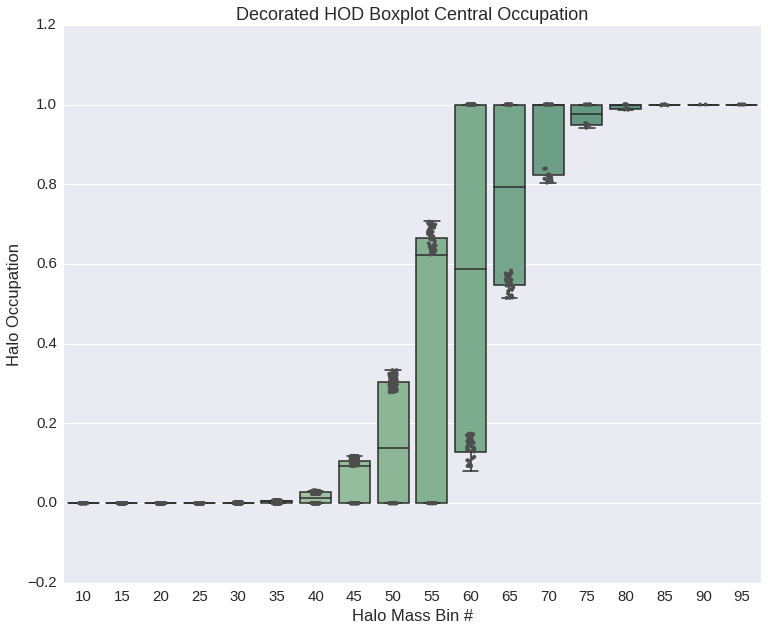

In [71]:
fig = plt.figure(figsize = (12.5,10))
#plt.plot(prim_haloprop_bins[bin_slice][sorted_idxs], baseline_result[bin_slice][sorted_idxs])
ax = sns.boxplot(x = prim_haloprop_bins[bin_slice], y = final_result[bin_slice], palette=pal)
sns.stripplot(x = prim_haloprop_bins[bin_slice][random_idxs], y = final_result[bin_slice][random_idxs],
              jitter=True, size=4, color=".3", linewidth=0)
sns.plt.title('Decorated HOD Boxplot Central Occupation')
sns.plt.xlabel('Halo Mass Bin #')
sns.plt.ylabel('Halo Occupation')

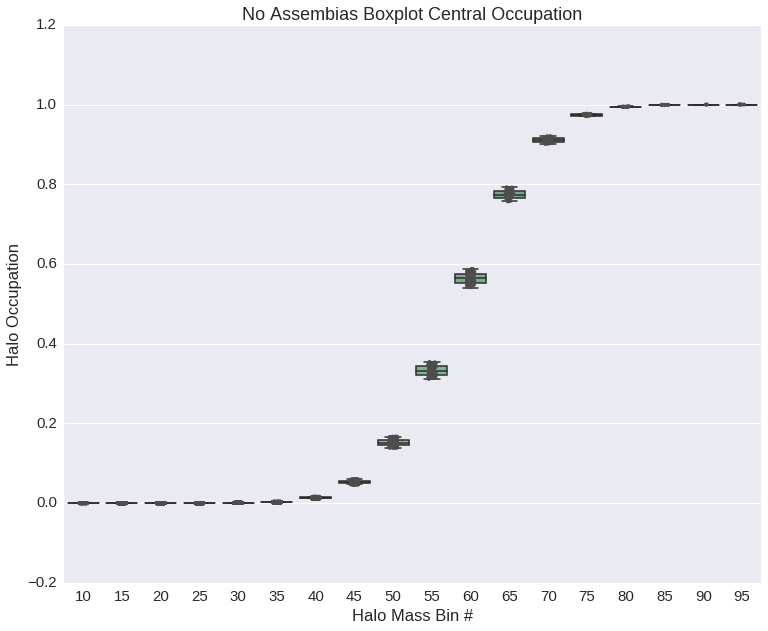

In [72]:
fig = plt.figure(figsize = (12.5,10))
#plt.plot(prim_haloprop_bins[bin_slice][sorted_idxs], baseline_result[bin_slice][sorted_idxs])
ax = sns.boxplot(x = prim_haloprop_bins[bin_slice], y = baseline_result[bin_slice], palette=pal)
sns.stripplot(x = prim_haloprop_bins[bin_slice][random_idxs], y = baseline_result[bin_slice][random_idxs],
              jitter=True, size=4, color=".3", linewidth=0)
sns.plt.title('No Assembias Boxplot Central Occupation')
sns.plt.xlabel('Halo Mass Bin #')
sns.plt.ylabel('Halo Occupation')

In [73]:
sat_occ = cat.model.model_dictionary['satellites_occupation']

In [74]:
sat_occ.modulate_with_cenocc = False
#sat_occ._decorate_baseline_method()

In [75]:
sat_occ.param_dict['mean_occupation_centrals_assembias_param1'] = 0.0
sat_occ.param_dict['mean_occupation_satellites_assembias_param1'] = 1.0

In [76]:
baseline_result = sat_occ.baseline_mean_occupation(prim_haloprop = prim_haloprop, sec_haloprop = sec_haloprop)
split = sat_occ.percentile_splitting_function(prim_haloprop = prim_haloprop)

In [77]:
no_edge_mask = ((split > 0) & (split < 1))

In [78]:
perturbation = sat_occ._galprop_perturbation(
    baseline_result = baseline_result[no_edge_mask],
    prim_haloprop = prim_haloprop[no_edge_mask],
    sec_haloprop = sec_haloprop[no_edge_mask],
    splitting_result = split[no_edge_mask])

In [79]:
final_result = sat_occ.mean_occupation(prim_haloprop = prim_haloprop, sec_haloprop = sec_haloprop)

In [80]:
pal = sns.cubehelix_palette(len(set(prim_haloprop_bins[bin_slice])), rot=0, dark=.3)

(-5, 15)

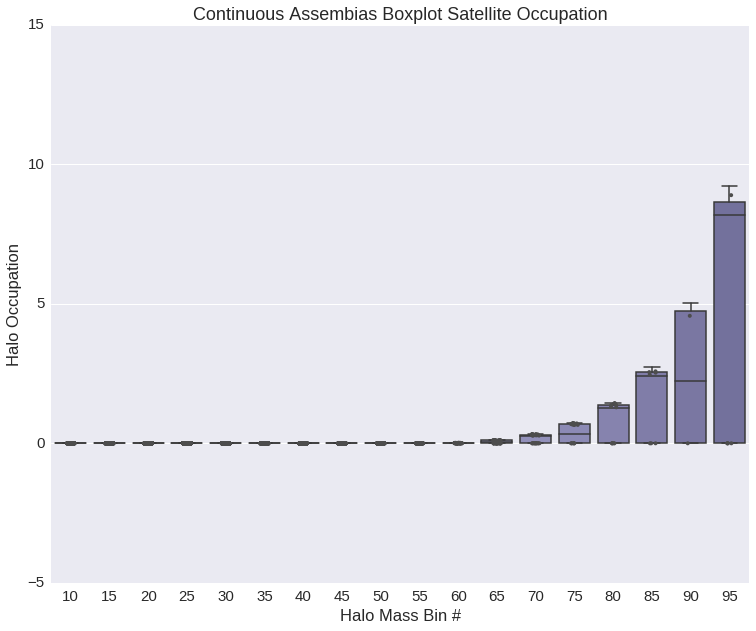

In [81]:
fig = plt.figure(figsize = (12.5,10))
#plt.plot(prim_haloprop_bins[bin_slice][sorted_idxs], baseline_result[bin_slice][sorted_idxs])
ax = sns.boxplot(x = prim_haloprop_bins[bin_slice], y = final_result[bin_slice], palette=pal)
sns.stripplot(x = prim_haloprop_bins[bin_slice][random_idxs], y = final_result[bin_slice][random_idxs],
              jitter=True, size=4, color=".3", linewidth=0)
sns.plt.title('Continuous Assembias Boxplot Satellite Occupation')
sns.plt.xlabel('Halo Mass Bin #')
sns.plt.ylabel('Halo Occupation')
plt.ylim([-5, 15])

(-5, 15)

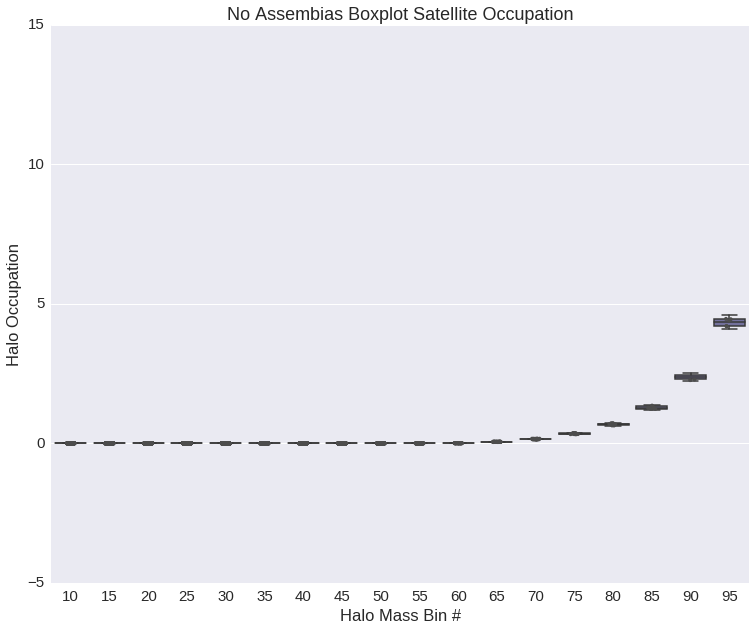

In [82]:
fig = plt.figure(figsize = (12.5,10))
#plt.plot(prim_haloprop_bins[bin_slice][sorted_idxs], baseline_result[bin_slice][sorted_idxs])
ax = sns.boxplot(x = prim_haloprop_bins[bin_slice], y = baseline_result[bin_slice], palette=pal)
sns.stripplot(x = prim_haloprop_bins[bin_slice][random_idxs], y = baseline_result[bin_slice][random_idxs],
              jitter=True, size=4, color=".3", linewidth=0)
sns.plt.title('No Assembias Boxplot Satellite Occupation')
sns.plt.xlabel('Halo Mass Bin #')
sns.plt.ylabel('Halo Occupation')
plt.ylim([-5, 15])